In [1]:
import os
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

In [2]:
folder_path = 'UTKFace'

In [3]:
age = []
gender = []
img_path = []
for file in os.listdir(folder_path):
    age.append(int(file.split('_')[0]))
    gender.append(int(file.split('_')[1]))
    img_path.append(file)

In [4]:
len(age)

23708

In [5]:
df = pd.DataFrame({'age': age, 'gender':gender,'img':img_path})

In [6]:
df.shape

(23708, 3)

In [7]:
df.sample(10)

,age,gender,img
10932,30,1,30_1_0_20170117141413713.jpg.chip.jpg
9063,28,1,28_1_0_20170116164219746.jpg.chip.jpg
5427,25,1,25_1_1_20170112205059883.jpg.chip.jpg
13957,36,0,36_0_3_20170119202129918.jpg.chip.jpg
16977,46,0,46_0_0_20170105173017060.jpg.chip.jpg
11948,32,1,32_1_0_20170105173150717.jpg.chip.jpg
3395,22,0,22_0_2_20170104021111388.jpg.chip.jpg
11977,32,1,32_1_0_20170116220851784.jpg.chip.jpg
12858,35,0,35_0_0_20170116222357299.jpg.chip.jpg
9148,28,1,28_1_1_20170112210934053.jpg.chip.jpg


In [8]:
train_df = df.sample(frac=1,random_state=0).iloc[:20000]
test_df = df.sample(frac=1,random_state=0).iloc[20000:]

In [9]:
train_df.shape

(20000, 3)

In [10]:
test_df.shape

(3708, 3)

In [11]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True
                                   )

test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
train_generator = train_datagen.flow_from_dataframe(train_df,directory=folder_path,x_col='img',y_col=['age','gender'],target_size=(200,200),class_mode='multi_output')

test_generator = test_datagen.flow_from_dataframe(test_df,directory=folder_path,x_col='img',y_col=['age','gender'],target_size=(200,200),class_mode='multi_output')

Found 20000 validated image filenames.
Found 3708 validated image filenames.


In [22]:
print(train_generator)

In [21]:
from keras.applications import VGG16,ResNet50
from keras.layers import *
from keras.models import Model

In [14]:
vggnet = VGG16(include_top=False,input_shape=(200,200,3))

In [15]:
vggnet.trainable=False
output = vggnet.layers[-1].output
flatten = Flatten()(output)


dense1 = Dense(512,activation='relu')(flatten)
dense2 = Dense(512,activation='relu')(flatten)

dense3 = Dense(512,activation='relu')(dense1)
dense4 = Dense(512,activation='relu')(dense2)

output1 = Dense(1,activation='linear',name='age')(dense3)
output2 = Dense(1,activation='sigmoid',name='gender')(dense4)

In [16]:
model = Model(inputs=vggnet.input, outputs=[output1,output2])

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 200, 200, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 200, 200, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)         0         ['block1_conv2[0][0]']        
                                                                                              

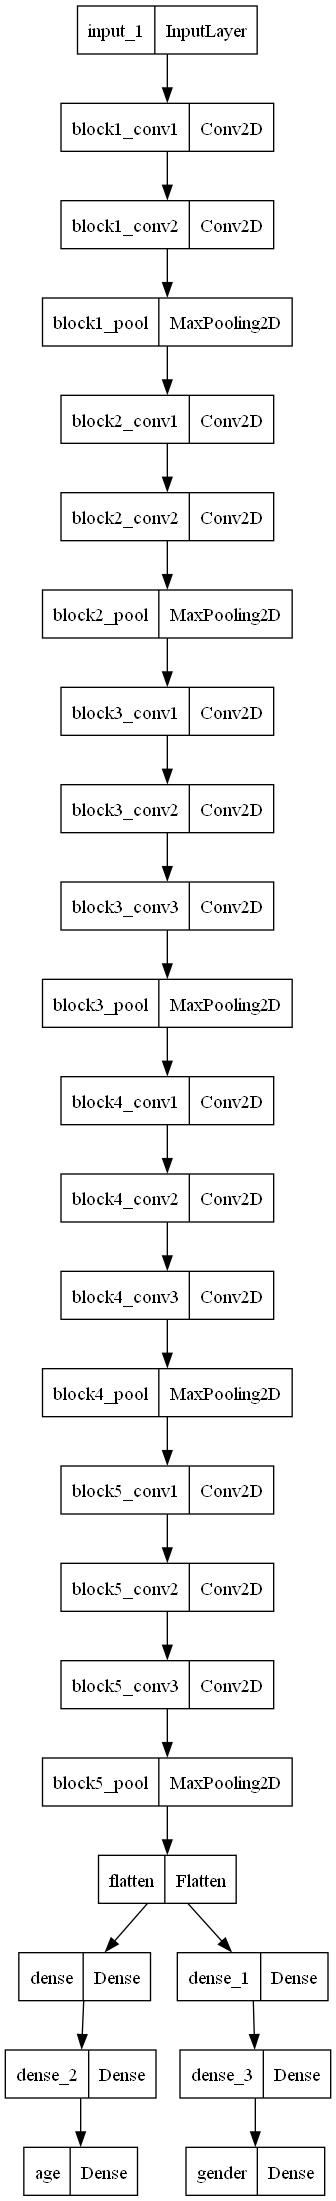

In [18]:
from keras.utils import plot_model
plot_model(model)

In [19]:
model.compile(optimizer='adam',loss={'age':'mae','gender':'binary_crossentropy'},metrics={'age':'mae','gender':'accuracy'},loss_weights={'age':1,'gender':99})

In [20]:
model.fit(train_generator,batch_size=128,epochs=1,validation_data=test_generator)

  5/625 [..............................] - ETA: 29:03 - loss: 191.8859 - age_loss: 23.8344 - gender_loss: 1.6975 - age_mae: 23.8344 - gender_accuracy: 0.5500

KeyboardInterrupt: 